# SIIIW Lista 5 raport - Krzysztof Otręba 266541

## Zadanie 1

W celu ekstrakcji cech wydobyłem z plików html samą treść żartu i usunąłem opisy w stylu "żart 15 z 20". Następnie wybrałem model bert base cased, ponieważ jest on używany w sytuacjach wymagających zrozuemienie tekstu, a fastText jest stowosowany w zadaniach wyamagających analizy tekstu na poziomie słów i fraz.

In [108]:
# Import danych
import os
import re
import html_text

jokes_dir = 'jokes'
jokes = {}

def extract_joke_text_from_html(input_html):
    text = html_text.extract_text(input_html)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'\b(A Joke|Joke \d+( of \d+)?)\b', '', text)  # Usunięcie wzorców typu 'A Joke', 'Joke 1 of 25', itp.
    text = text.strip()
    return text

for file in os.listdir(jokes_dir):
    if file.endswith('.html'):
        with open(os.path.join(jokes_dir, file), 'r') as f:
            joke_text = extract_joke_text_from_html(f.read())
            jokes[int(file.replace('.html', '').replace('init', ''))] = joke_text

for i in range(1, 4):
    print(f'Joke {i}: {jokes[i]}')

Joke 1: A man visits the doctor. The doctor says "I have bad news for you.You have cancer and Alzheimer's disease". The man replies "Well,thank God I don't have cancer!"
Joke 2: This couple had an excellent relationship going until one day he came home from work to find his girlfriend packing. He asked her why she was leaving him and she told him that she had heard awful things about him. "What could they possibly have said to make you move out?" "They told me that you were a pedophile." He replied, "That's an awfully big word for a ten year old."
Joke 3: Q. What's 200 feet long and has 4 teeth? A. The front row at a Willie Nelson Concert.


In [109]:
# Ekstrakcja cech
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('bert-base-cased')

embeddings = model.encode(list(jokes.values()))
embeddings.shape

No sentence-transformers model found with name bert-base-cased. Creating a new one with mean pooling.
/Users/krzysztofotreba/studia/sem6/ai/jokes-rating-ai/venv/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


(100, 768)

Zaimportowałem wszystkie 3 pliki z ocenami. Usunąłem z nich wartości puste i połączyłem w jeden dataframe. Jako oś y wybrałem średnie wartości ocen żartów. Dane walidacyjne to 20% zbioru.

In [110]:
# import ocen
import pandas as pd

file_list = ['jester-data-1.xls', 'jester-data-2.xls', 'jester-data-3.xls']

df_list = []

for file in file_list:
    df = pd.read_excel(file, header=None, na_values=[99])
    df_list.append(df)

combined_df = pd.concat(df_list, ignore_index=True)

ratings = combined_df.drop(combined_df.columns[0], axis=1)

print(ratings.info())
print(ratings.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73421 entries, 0 to 73420
Data columns (total 100 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   1       32024 non-null  float64
 1   2       35277 non-null  float64
 2   3       32402 non-null  float64
 3   4       30512 non-null  float64
 4   5       73405 non-null  float64
 5   6       39599 non-null  float64
 6   7       73401 non-null  float64
 7   8       73411 non-null  float64
 8   9       30741 non-null  float64
 9   10      39352 non-null  float64
 10  11      42677 non-null  float64
 11  12      43564 non-null  float64
 12  13      73405 non-null  float64
 13  14      43899 non-null  float64
 14  15      73406 non-null  float64
 15  16      73399 non-null  float64
 16  17      73413 non-null  float64
 17  18      73404 non-null  float64
 18  19      73406 non-null  float64
 19  20      73410 non-null  float64
 20  21      57706 non-null  float64
 21  22      41818 non-null  float64
 2

In [111]:
from sklearn.model_selection import train_test_split


mean_ratings = ratings.mean().to_list()
print(mean_ratings[:5])

x_train, x_test, y_train, y_test = train_test_split(embeddings, mean_ratings, test_size=0.2, random_state=21)

[0.9019966275293531, 0.1629891997618845, 0.19341090056169372, -1.4125989774514944, 0.23535236019344732]


## Zadanie 2
Przetestowałem domyślny model w 200 epokach. Z wykresu wynika, że model na początku po około 10 epokach osiągnął najlepsze dopasowanie do danych walidacyjnych, a później nastąpiło zjawisko overfittingu do danych treningowych.

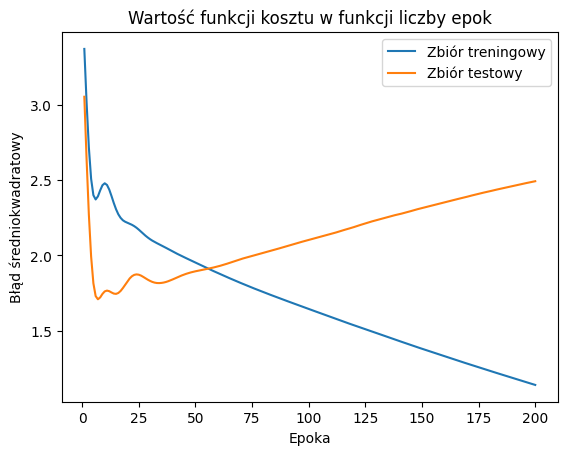

In [112]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

EPOCHS_LIMIT = 200
t_errors, v_errors = [], []
mlp = MLPRegressor(solver='sgd', alpha=0.0, learning_rate='constant', random_state=21)
for _ in range(EPOCHS_LIMIT):
    mlp.partial_fit(x_train, y_train)
    t_errors.append(mean_squared_error(y_train, mlp.predict(x_train)))
    v_errors.append(mean_squared_error(y_test, mlp.predict(x_test)))

plt.plot(range(1, EPOCHS_LIMIT + 1), t_errors, label='Zbiór treningowy')
plt.plot(range(1, EPOCHS_LIMIT + 1), v_errors, label='Zbiór testowy')
plt.title('Wartość funkcji kosztu w funkcji liczby epok')
plt.xlabel('Epoka')
plt.ylabel('Błąd średniokwadratowy')
plt.legend()
plt.show()

## Zadanie 3
Przetestowałem learning rate na wartościach od 0,000001 do 0.001. Najniższa wartość powowdała bardzo wolne uczucie się. Optymalną wartością okazało się 0.0001. Wyższe wartości skutkowały wystąpieniem overfittingu.

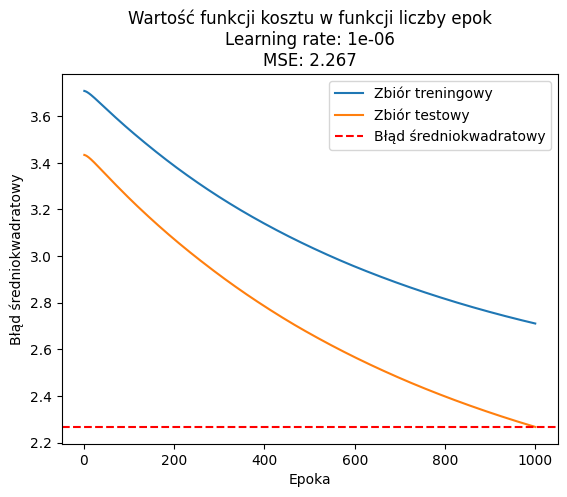

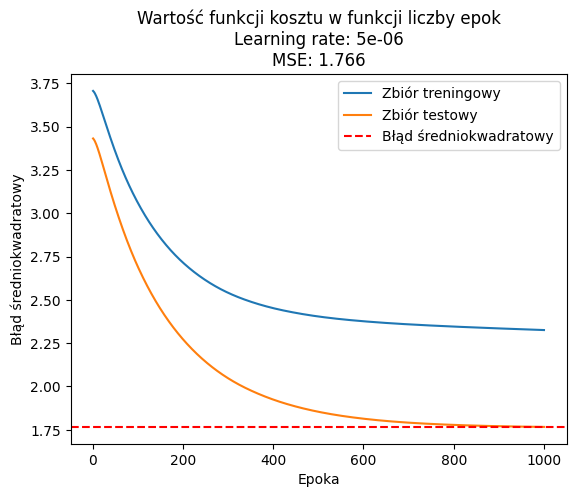

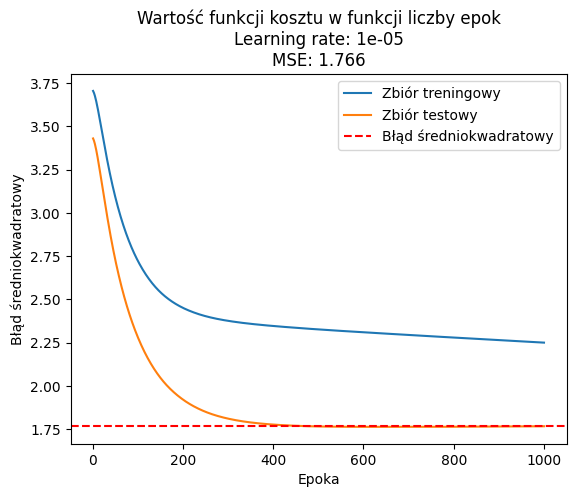

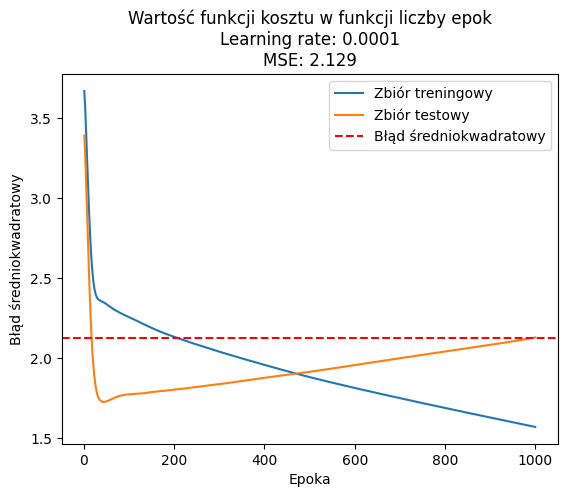

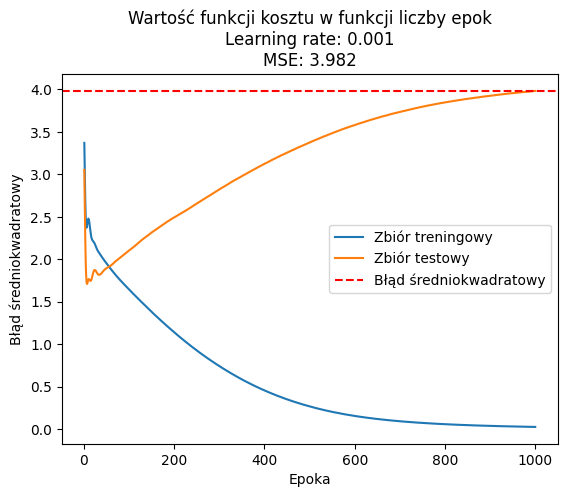

In [113]:
def test_learning_rate(learning_rate, epochs_limit=EPOCHS_LIMIT):
    mlp = MLPRegressor(solver='sgd', alpha=0.0, learning_rate='constant', learning_rate_init=learning_rate, random_state=21)
    t_errors, v_errors = [], []
    for _ in range(epochs_limit):
        mlp.partial_fit(x_train, y_train)
        t_errors.append(mean_squared_error(y_train, mlp.predict(x_train)))
        v_errors.append(mean_squared_error(y_test, mlp.predict(x_test)))
    
    mse = mean_squared_error(y_test, mlp.predict(x_test))
    
    plt.plot(range(1, epochs_limit + 1), t_errors, label='Zbiór treningowy')
    plt.plot(range(1, epochs_limit + 1), v_errors, label='Zbiór testowy')
    plt.title(f'Wartość funkcji kosztu w funkcji liczby epok\nLearning rate: {learning_rate}\nMSE: {round(mse, 3)}')
    plt.xlabel('Epoka')
    plt.ylabel('Błąd średniokwadratowy')
    plt.axhline(mse, color='r', linestyle='--', label='Błąd średniokwadratowy')
    plt.legend()
    plt.show()
    return mse

learning_rates = [0.000001, 0.000005, 0.00001, 0.0001, 0.001]
for lr in learning_rates:
    test_learning_rate(lr, 1000)

## Zadanie 4
W celu znalezienia optymalnej liczby neuronów przetestowałem najpierw modele z jedną wartswą, a następnie z dwiema.
Zbyt małe liczby wartsw skutkowały underfittingiem - tzn model nie miał miejsca, aby pomieścić wszystkie potrzebne informacje i wyniki były gorsze.
Zbyt duża liczba warstw skutkowała zjawiskiem wystąpienia overfittingu.
Optymalną wartością dla jednej wartstwy okazało się 100, a dla dwóch wartsw (200, 200). Wyniki są bardzo zbliżone.

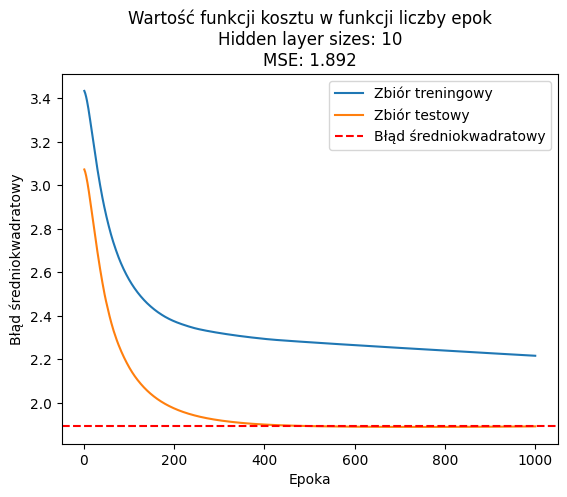

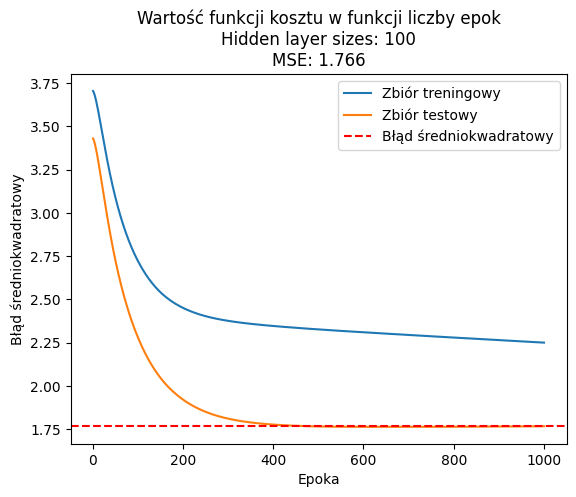

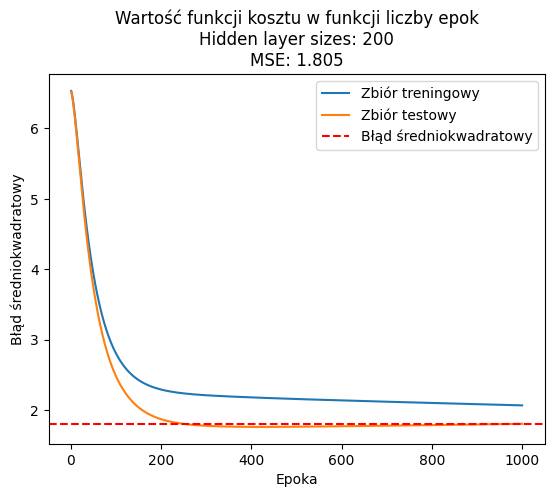

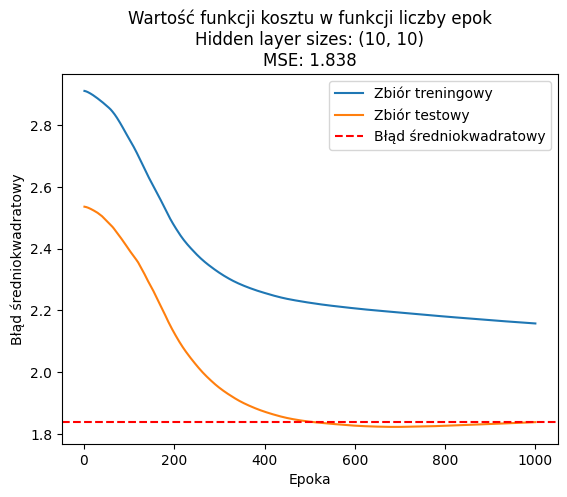

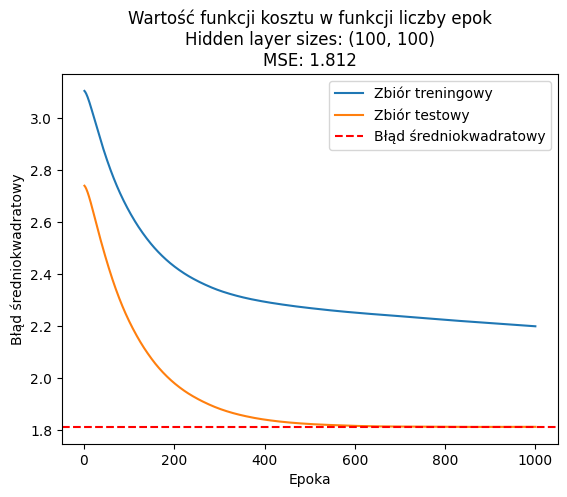

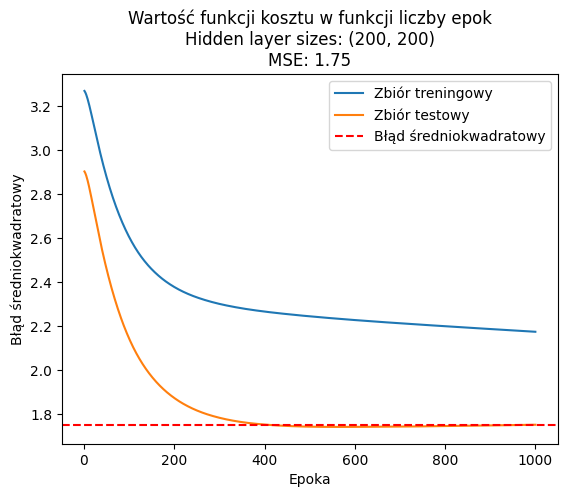

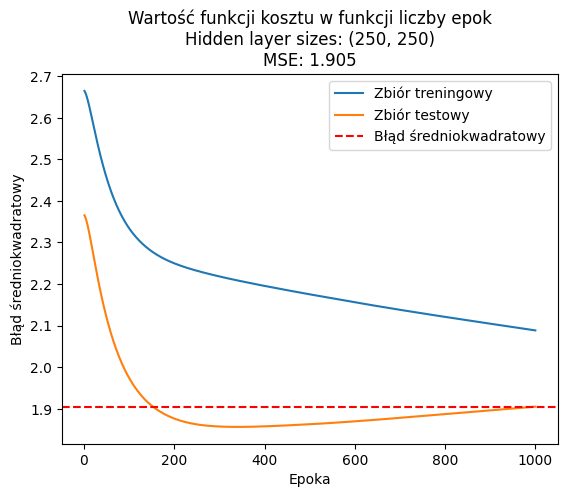

In [114]:
def test_size(sizes=(20, 20), epochs_limit=EPOCHS_LIMIT):
    mlp = MLPRegressor(hidden_layer_sizes=sizes, solver='sgd', alpha=0.0, learning_rate='constant', learning_rate_init=0.00001, random_state=21)
    t_errors, v_errors = [], []
    for _ in range(epochs_limit):
        mlp.partial_fit(x_train, y_train)
        t_errors.append(mean_squared_error(y_train, mlp.predict(x_train)))
        v_errors.append(mean_squared_error(y_test, mlp.predict(x_test)))
    
    mse = mean_squared_error(y_test, mlp.predict(x_test))
    
    plt.plot(range(1, epochs_limit + 1), t_errors, label='Zbiór treningowy')
    plt.plot(range(1, epochs_limit + 1), v_errors, label='Zbiór testowy')
    plt.title(f'Wartość funkcji kosztu w funkcji liczby epok\nHidden layer sizes: {sizes}\nMSE: {round(mse, 3)}')
    plt.xlabel('Epoka')
    plt.ylabel('Błąd średniokwadratowy')
    plt.axhline(mse, color='r', linestyle='--', label='Błąd średniokwadratowy')
    plt.legend()
    plt.show()
    return mse

sizes = [(10), (100), (200), (10, 10), (100, 100), (200, 200), (250, 250)]
for s in sizes:
    test_size(s, 1000)

## Zadanie 5
W celu przetestowania modelu znalazłem kilka żartów różnego typu (normalne żarty, czarny humor) oraz losowe teksty, które wcale nie są żartami.
Model ocenił faktycznie żarty nieznacznie lepiej od nieżartów, jednak nadal najlepiej z całego zbioru ocenił zwrot "xd", co jest dość rozczarowujące. Myślę, że jest to spowodowane tym, że model nie uczył odróżniać żarty od nieżartów. Jednak sama ocena faktycznych żartów wydaje się dość losowa. Prawdopodobnie jest to spowodwone tym, że żarty są mocno subiektywne i ciężko stworzyć model, który umiałby je oceniać.

In [115]:
jokes = [
    'These are just some random words to test the model.', # random text
    'xd', #random word
    'Why did the tomato turn red? Because it saw the salad dressing!', # normal safe decent joke
    "My grief counselor died. He was so good, I don't even care.", # dark humour
    "I'm not saying my wife's a bad cook, but she uses a smoke alarm as a timer.", # sexist joke
    "Did you know that the Eiffel Tower was originally intended to be a temporary installation for the 1889 World's Fair in Paris?", # asked chat gpt to generate a bad joke
    "Lorem ipsum dolor sit amet, consectetur adipiscing elit. Nullam nec purus Lorem ipsum dolor sit amet, consectetur adipiscing elit. Nullam nec purus Lorem ipsum dolor sit amet, consectetur adipiscing elit. Nullam nec purus Lorem ipsum dolor sit amet, consectetur adipiscing elit. Nullam nec purus Lorem ipsum dolor sit amet, consectetur adipiscing elit. Nullam nec purus" # lorem ipsum
]

jokes_embeddings = model.encode(jokes)
mlp = MLPRegressor(hidden_layer_sizes=(200, 200), solver='sgd', alpha=0.0, learning_rate='constant',
                   learning_rate_init=0.00001, random_state=21, max_iter=1000)
mlp.fit(x_train, y_train)
for i, j in enumerate(jokes):
    print(f'Joke {i + 1}: {j}\nPredicted rating: {mlp.predict(jokes_embeddings[i].reshape(1, -1))[0]:.2f}\n')




Joke 1: These are just some random words to test the model.
Predicted rating: 0.40

Joke 2: xd
Predicted rating: 0.78

Joke 3: Why did the tomato turn red? Because it saw the salad dressing!
Predicted rating: 0.61

Joke 4: My grief counselor died. He was so good, I don't even care.
Predicted rating: 0.51

Joke 5: I'm not saying my wife's a bad cook, but she uses a smoke alarm as a timer.
Predicted rating: 0.55

Joke 6: Did you know that the Eiffel Tower was originally intended to be a temporary installation for the 1889 World's Fair in Paris?
Predicted rating: 0.47

Joke 7: Lorem ipsum dolor sit amet, consectetur adipiscing elit. Nullam nec purus Lorem ipsum dolor sit amet, consectetur adipiscing elit. Nullam nec purus Lorem ipsum dolor sit amet, consectetur adipiscing elit. Nullam nec purus Lorem ipsum dolor sit amet, consectetur adipiscing elit. Nullam nec purus Lorem ipsum dolor sit amet, consectetur adipiscing elit. Nullam nec purus
Predicted rating: 0.35



## Zadanie 6
Do przetestowania wybrałem parametr momentum. Odpowiada on za to jak szybko model uczy się z poprzednich gradientów. Dostępny jest on tylko dla sovlera sgd. Zazwyczaj wartości parametru mieszczą się w przedziale od 0 do 1.
Najlepszą skuteczność model osiągnął dla momentum 0,9. Niższe wartości skutkowały zbyt powolnym uczeniem się, a wartość 1 sprawiła, że wyniki są zupełnie losowe.

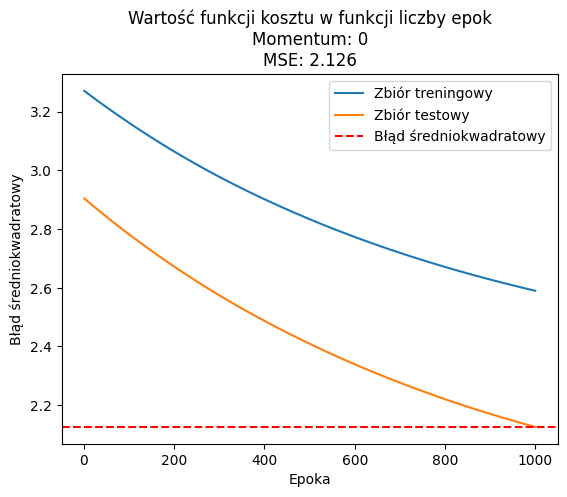

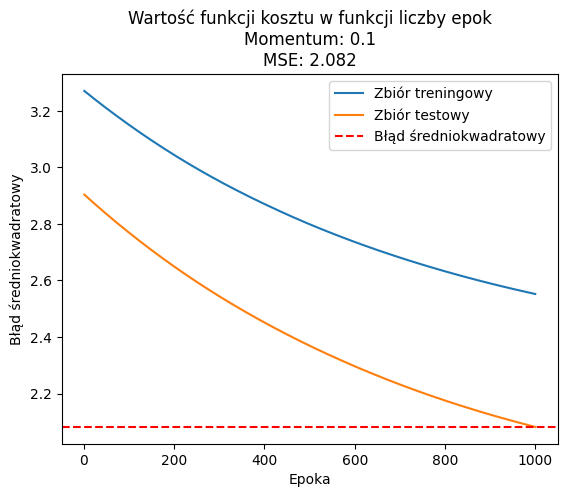

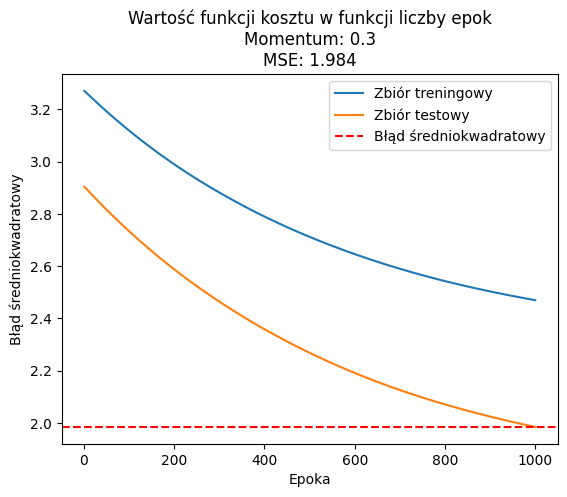

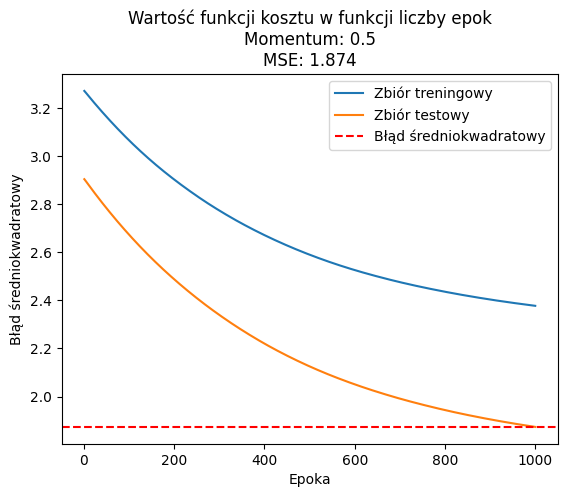

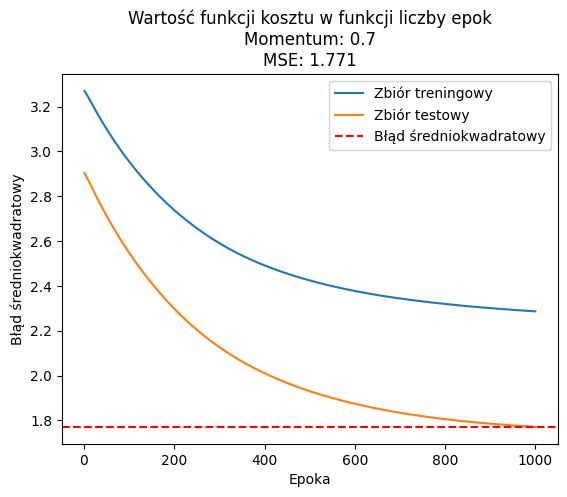

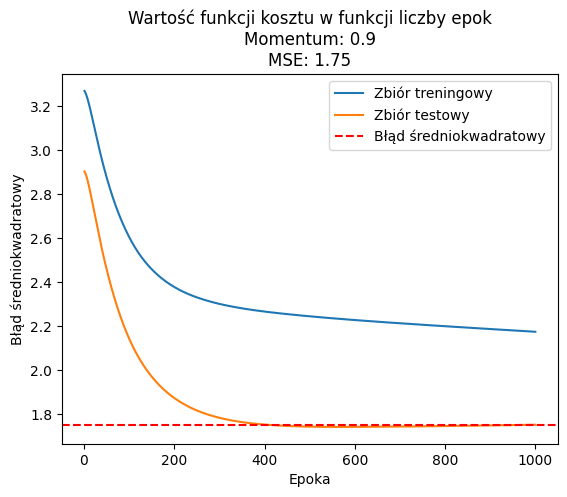

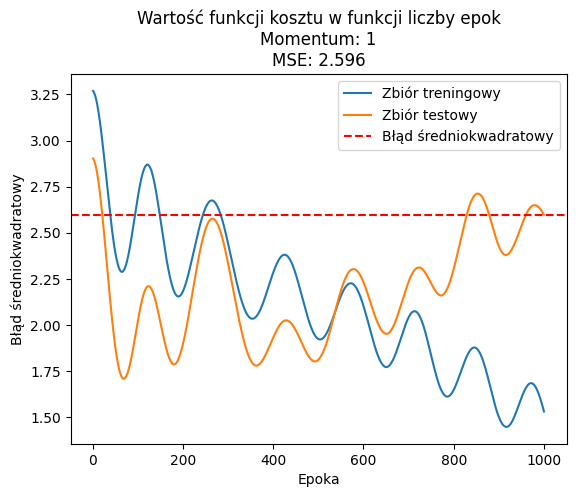

In [116]:
momentums = [0, 0.1, 0.3, 0.5, 0.7, 0.9, 1]
EPOCHS_LIMIT = 1000

def test_momentum(momentum: 0.5):
    mlp = MLPRegressor(hidden_layer_sizes=(200, 200), solver='sgd', alpha=0.0, learning_rate='constant',
                       learning_rate_init=0.00001, momentum=momentum, random_state=21, max_iter=1000)
    t_errors, v_errors = [], []
    for _ in range(EPOCHS_LIMIT):
        mlp.partial_fit(x_train, y_train)
        t_errors.append(mean_squared_error(y_train, mlp.predict(x_train)))
        v_errors.append(mean_squared_error(y_test, mlp.predict(x_test)))
    
    mse = mean_squared_error(y_test, mlp.predict(x_test))
    
    plt.plot(range(1, EPOCHS_LIMIT + 1), t_errors, label='Zbiór treningowy')
    plt.plot(range(1, EPOCHS_LIMIT + 1), v_errors, label='Zbiór testowy')
    plt.title(f'Wartość funkcji kosztu w funkcji liczby epok\nMomentum: {momentum}\nMSE: {round(mse, 3)}')
    plt.xlabel('Epoka')
    plt.ylabel('Błąd średniokwadratowy')
    plt.axhline(mse, color='r', linestyle='--', label='Błąd średniokwadratowy')
    plt.legend()
    plt.show()
    return mse

for m in momentums:
    test_momentum(m)